In [2]:
import numpy as np
import os
import random
from sys import platform as sys_pf
import matplotlib
if sys_pf == 'darwin':
	matplotlib.use("TkAgg")
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names

def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I)
	return I
# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

generating figure 1 of 1


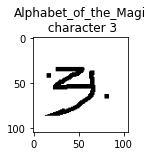

In [4]:
num_alphabets = 1
num_samples = 1
for a in range(num_alphabets): # for each alphabet
        print('generating figure ' + str(a+1) + ' of ' + str(num_alphabets))
        alpha_name = alphabet_names[a]
        
        # choose a random character from the alphabet
        character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

        # get image directory for this character
        img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))


        # get base file name for this character
        fn_example = os.listdir(img_char_dir)[0]
        fn_base = fn_example[:fn_example.find('_')] 

        plt.figure(a,figsize=(10,8))
        plt.clf()
        for r in range(1,num_samples+1): # for each rendition
            plt.subplot(4,5,r)
            fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
            I = load_img(fn_img)
            plt.imshow(I, cmap='gray')
            if r==1:
                plt.title(alpha_name[:20] + '\n character ' + str(character_id))


In [5]:
def load_data(alphabet_names):
    X = np.array([])
    Y = np.array([])
    for alpha_name in alphabet_names:
        char_ids = range(1,len(os.listdir(os.path.join(img_dir,alpha_name))) + 1)
        # get image directory for this character
        for char_id in char_ids:
            img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(char_id))
            # get list of individual file names for each sample of a character
            img_fns = os.listdir(img_char_dir)
            # np arrays containing data of all samples of a character
            data = np.array([plt.imread(os.path.join(img_char_dir, fn)) for fn in img_fns])
            for i in range(len(img_fns)):
              Y = np.append(Y, alpha_name + '_character'+num2str(char_id)) # within alphabet discrimination
              # Y = np.append(Y, alpha_name) # between alphabet discrimination
            if X.size == 0:
                X = data
            else:
                X = np.vstack((X, data))

        
    return X, Y



In [6]:
def make_pairs(X, Y):

    pairs = []
    labels = []

    for i in range(len(X)):
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        J = [j for j, y in enumerate(Y) if y == class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [1]

        # get non-match
        # get possible indices where x2 is different from x1
        J = [j for j, y in enumerate(Y) if y != class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [0]
        
    return np.array(pairs), np.array(labels)




1
0
1
0
1
0
1
0
1
0


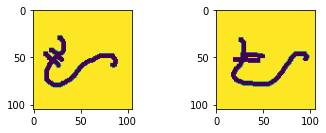

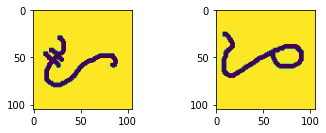

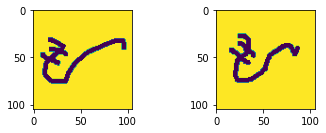

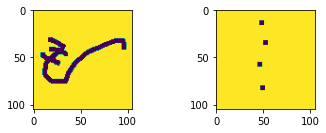

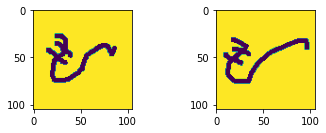

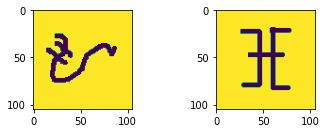

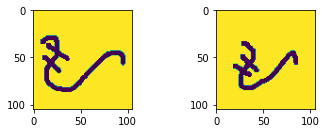

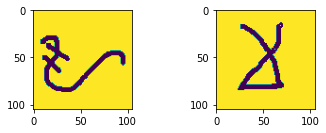

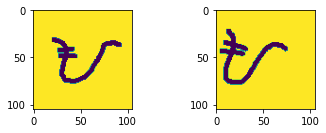

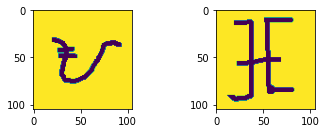

In [9]:
train_alphabets = alphabet_names[:5] # get first n alphabets (classes)
test_alphabets = alphabet_names[len(alphabet_names)-2:]

X_train, Y_train = load_data(train_alphabets)
X_test, Y_test = load_data(test_alphabets)

train_pairs, train_labels = make_pairs(X_train, Y_train)
train_pairs, train_labels = make_pairs(X_test, Y_test)

for i in range(10):
    print(train_labels[i])
    fig = plt.figure()

    plt.subplot(2,2,1)
    plt.imshow(train_pairs[i][0])
    plt.subplot(2,2,2)
    plt.imshow(train_pairs[i][1])



In [10]:
print(train_pairs.shape)

(2880, 2, 105, 105)


In [11]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    # model = Model(Input(input_shape))
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                    kernel_initializer='random_normal', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    # model.add(Conv2D(128, (7,7), activation='relu',
    #                     kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    # model.add(MaxPooling2D())
    # model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    # model.add(MaxPooling2D())
    # model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer='random_normal',
    #                     bias_initializer='zeros', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer='random_normal',bias_initializer='zeros'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net

In [12]:
model = get_siamese_model((105,105,1))
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

AttributeError: 'Model' object has no attribute 'add'

In [ ]:
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=1)